In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Build the graph

In [2]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

from app.schemas import InterviewState, ResearchGraphState
from app.nodes import generate_question, search_web, search_wikipedia, generate_answer, save_interview
from app.nodes import create_analysts, human_feedback, create_outline, write_report
from app.routes import route_messages, initiate_all_interviews

In [3]:
# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", END)

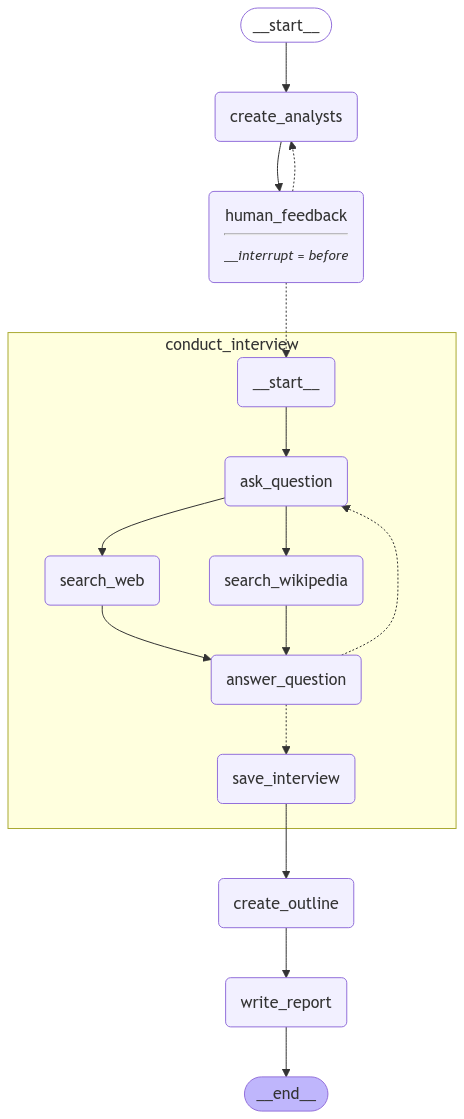

In [4]:
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("create_outline", create_outline)
builder.add_node("write_report", write_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "create_outline")
builder.add_edge("create_outline", "write_report")
builder.add_edge("write_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

### Manual Testing

In [5]:
# Inputs
max_analysts = 3 
topic = "Marketing cozy games for steam"
thread = {"configurable": {"thread_id": "3"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Lila Chen
Affiliation: Game Marketing Agency
Role: Marketing Strategist
Description: Lila focuses on developing marketing strategies specifically for indie games, with a keen interest in the cozy game genre. She analyzes market trends, audience demographics, and effective promotional tactics to enhance visibility on platforms like Steam.
--------------------------------------------------
Name: Marcus Rivera
Affiliation: Indie Game Developer
Role: Game Designer
Description: Marcus is an indie game developer who specializes in creating cozy games. He provides insights into the creative process, player engagement, and the importance of community feedback in shaping marketing efforts for his games.
--------------------------------------------------
Name: Sophie Patel
Affiliation: Gaming Community Influencer
Role: Content Creator
Description: Sophie is a popular gaming influencer who focuses on cozy games. She shares her experiences and reviews on social media platforms, and her persp

In [ ]:
graph.update_state(thread, {"human_analyst_feedback": 
                                "Instead of the Technology Consultant, add a solo game developer"}, as_node="human_feedback")

In [ ]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

In [ ]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

In [6]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
human_feedback
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
create_outline
--Node--
write_report


In [7]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('report')
Markdown(report)

# Marketing Cozy Games for Steam

## Introduction

Cozy games have emerged as a beloved genre within the gaming market, particularly on platforms like Steam. Characterized by their charming aesthetics, relaxing gameplay, and community-driven experiences, cozy games appeal to a diverse audience seeking comfort and escapism. As the popularity of this genre continues to grow, it is essential for indie developers to adopt tailored marketing strategies that effectively reach and engage their target audience.

## Understanding the Cozy Game Market

The cozy game genre encompasses a variety of gameplay styles, often featuring elements such as base-building, farming, and exploration. The target audience for these games typically includes players looking for immersive and low-stress experiences. Recent trends indicate a rising demand for games that promote relaxation and mindfulness, making it crucial for developers to understand the preferences and motivations of their audience to craft effective marketing strategies.

## Key Marketing Strategies for Cozy Games

To successfully market cozy games on Steam, developers should consider the following comprehensive strategies:

### Participating in Events

Events like Steam Next Fest and Wholesome Direct play a vital role in enhancing visibility and fostering community engagement. These events provide developers with opportunities to showcase their games through demos, gather player feedback, and connect with potential fans. For instance, games like "Ooblets" and "Cozy Grove" have successfully utilized these events to boost their visibility and engage with players [1][2].

### Optimizing Store Pages

Creating appealing store pages is essential for attracting potential players. Developers should focus on high-quality visuals, clear descriptions, and engaging trailers that highlight the unique charm of their games. An optimized store page can significantly increase wishlist numbers and player interest.

### Creating Compelling Demos

Engaging demos are crucial for showcasing the core mechanics and charm of cozy games. By allowing players to experience the game firsthand, developers can generate excitement and community interest. Successful demos, like those seen during Steam Next Fest, can lead to increased visibility and player engagement [1][2].

### Leveraging Influencer Marketing

Influencer marketing can amplify the reach and visibility of cozy games. Collaborating with content creators and streamers allows developers to tap into established audiences and generate buzz around their games. For example, "Animal Crossing: New Horizons" saw significant visibility through influencer gameplay streams, which contributed to its success [1][2].

### Engaging with the Community

Building and maintaining a community around cozy games is essential for long-term success. Developers should actively engage with players through social media, forums, and community events. This engagement fosters loyalty and creates a supportive environment that enhances player experience [1][2].

## Building a Community

Fostering a strong community before and after a game's launch involves several effective tactics:

### Utilizing Social Media

Platforms like Twitter, Instagram, and TikTok can be powerful tools for engaging with potential players. Developers should share development updates, behind-the-scenes content, and relatable posts to create a sense of connection with their audience [2].

### Creating Discord Communities

Establishing a dedicated Discord server allows for direct communication and interaction among players. This space can facilitate feedback, community events, and exclusive content sharing, enhancing player investment in the game [2].

### Encouraging User-Generated Content

Motivating players to create and share content, such as fan art or gameplay videos, can help spread the word about the game. User-generated content serves as authentic marketing material that resonates with potential players [1].

### Regular Updates and Communication

Maintaining transparency and providing regular updates about game improvements and new features keeps the community engaged. Listening to player feedback and sharing the development process fosters trust and strengthens the relationship between developers and players [2].

## Case Studies of Successful Cozy Games

### Stardew Valley

"Stardew Valley" exemplifies successful community engagement through active developer interaction and support for modding. The game's creator, ConcernedApe, frequently engages with players on social media, fostering trust and loyalty. The game's strong presence on platforms like Reddit allows players to share tips and experiences, creating a vibrant community [1][2].

### Ooblets

"Ooblets" effectively utilized engaging demos and social media engagement during events like Steam Next Fest to boost visibility. The developers optimized their store page and actively engaged with players, leading to increased community interest [1][2].

### Animal Crossing: New Horizons

The impact of influencer marketing on "Animal Crossing: New Horizons" showcases the power of community engagement. Influencers streamed gameplay, shared personal stories, and organized collaborative events, generating significant buzz and contributing to the game's status as a best-seller [1][2].

## Emerging Trends in Cozy Gaming

Developers should be aware of several emerging trends in the cozy gaming space when planning their marketing strategies:

### Focus on Community Building

The importance of community in the cozy gaming space is growing. Developers should prioritize creating platforms for players to connect and share experiences [1].

### Mindfulness and Relaxation Elements

Incorporating calming features, such as soothing soundtracks and low-stress gameplay mechanics, can attract players seeking relaxation [2].

### Cross-Platform Play and Accessibility

With the rise of mobile gaming, cozy games that allow cross-platform play are gaining popularity. Developers should consider making their games accessible on multiple platforms to reach a broader audience [1].

### Sustainability Themes

Games that promote sustainability and environmental awareness resonate well with players who value these messages. Incorporating eco-friendly themes can enhance a game's appeal [2].

### Diverse Representation

Inclusive narratives and characters that reflect a variety of backgrounds and experiences are increasingly important to players. Developers should aim to create diverse representation in their games [1].

## Conclusion

Marketing cozy games on Steam requires a strategic approach that emphasizes community engagement, effective use of events, and tailored marketing tactics. By understanding the preferences of their audience and implementing best practices, indie developers can successfully promote their cozy games and tap into the growing market. As the cozy gaming genre continues to evolve, staying attuned to emerging trends will be essential for long-term success.

## References

[1] https://practicalmedia.io/article/Analyzing-the-Success-of-Cozy-Games-on-Steam-in-2025  
[2] https://www.biggamesmachine.com/steam-next-fest-marketing-strategies/  
[3] https://www.conduit.gg/blog/posts/mastering-steam-success-a-comprehensive-guide-to-marketing-indie-games-effectively  
[4] https://www.brandwatch.com/blog/cozy-games-community/  
[5] https://gameinfluencer.com/5-examples-of-excellent-gaming-influencer-campaigns/  
[6] https://inbeat.agency/blog/video-game-influencer-marketing  

In [ ]:
final_state.values